# Interactive Demo with Emission Lines

This notebook outlines the motivation, theory, implementation, and application of Prospector to fit spectro-photometry including the impact of emission lines.

## Preamble

First let's set up some environmental dependencies. These just make the numerics easier and adjust some of the plotting defaults to make things more legible.

In [1]:
# pylab environment
%pylab 

# inline plotting
%matplotlib inline 

import time, sys, os # system utilities
from scipy import stats # statistics functions
import fit_utils as fit # fitting utilities
import pickle # saving/loading results

# re-defining plotting defaults
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

from corner import corner

fout = sys.stdout # stdout path
fnull = open(os.devnull, 'w') # null path

c = 3e8 # speed of light [m/s]
lsun = 3.846e33  # solar luminosity [ergs/s]
pc = 3.085677581467192e18  # parsec [cm]
jansky_mks = 1e-26 # conversion to Jy [in mks]
jy_cgs = 1e-23 # conversion to Jy [in cgs]
AB_zero = 3631 # AB zeropoint [Jy]
to_cgs = lsun/(4.0 * pi * (pc*10)**2 ) # convert from L_sun to flux [erg/s/cm^2] at 10pc

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


/home/joshspeagle/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


**Prospector** utilizes three main packages:
- **fsps**, which governs the fundamental stellar population synthesis models (via the **python-fsps** package),
- **sedpy**, which utilizes some routines for computing spectrophotometry, and
- **prospect**, which is where most of the actual heavy lifting is done.

Let's import those now.

In [2]:
import fsps
import sedpy
import prospect

## Continuum Model

We now want to initialize our baseline (continuum) SED model using our model parameter file.

In [3]:
from prospect.models import model_setup
clargs = {'param_file':'demo_mock_params.py'}
run_params = model_setup.get_run_params(argv='demo_mock_params.py', **clargs)
print run_params

{'tau': 80.0, 'verbose': True, 'niter': 512, 'normalize_spectrum': False, 'whi': 7200.0, 'initial_disp': 0.1, 'outfile': 'output/demo_mock', 'nburn': [32, 32, 64], 'maxfev': 5000, 'do_powell': True, 'nwalkers': 128, 'mass': 10000000.0, 'param_file': 'demo_mock_params.py', 'ftol': 5e-06, 'logzsol': -0.5, 'dust2': 0.3, 'tage': 0.5, 'zcontinuous': 1, 'wlo': 3750.0, 'debug': False, 'snr': 20.0, 'add_noise': False, 'logify_spectrum': False}


Our model is composed of four components:
- an **stellar population synthesis (SPS)** model for the underlying physical parameters,
- a **noise model** for the underlying calibration vector,
- an underlying **statistical model** composed of a set of parameters, priors, etc., and
- a set of **observations** we are trying to fit.

See the *demo_mock_params.py* file for additional info on the specific parameters we are initializing here.

In [4]:
sps = model_setup.load_sps(**run_params) # sps object
spec_noise, phot_noise = model_setup.load_gp(**run_params) # noise model (none)
model = model_setup.load_model(**run_params) # prospector object model
obs = model_setup.load_obs(**run_params) # observations

reading py script demo_mock_params.py


Let's now initialize our data. We'll be fitting $S/N=20$ photometry and a $S/N \sim 4$ SDSS-like spectrum.

In [5]:
# initialize data
obs['unc'] = ones_like(obs['true_spectrum']) * median(obs['true_spectrum']) / 4. # S/N = 4
obs['mask'] = ones_like(obs['unc'], dtype='bool')
obs['spectrum'] = normal(obs['true_spectrum'], obs['unc']) # jitter
obs['maggies'] = normal(obs['true_maggies'], obs['maggies_unc']) # jitter
Nspec, Nphot, Nfull = len(obs['spectrum']), len(obs['maggies']), len(sps.csp.wavelengths)

### Model Preview

Our model is essentially a black box that takes in a set of physical parameters $\boldsymbol{\theta}$ and returns a spectral and photometric flux density vectors (measured in maggies, i.e. per frequency) $\lbrace \mathbf{S}_{\textrm{cont}}(\boldsymbol{\theta}), \mathbf{F}_{\textrm{cont}}(\boldsymbol{\theta}) \rbrace$.

Let's take a quick look at our model/data to get a sense of what we're dealing with and what we're fitting for.

In [6]:
Ntheta = len(model.free_params)
theta_truth = array([obs['mock_params'][par] for par in model.free_params]).flatten()
print 'Free params:', model.free_params
print 'Values:', theta_truth
print 'Fixed params:', model.fixed_params

Free params: ['mass', 'logzsol', 'tau', 'tage', 'dust2']
Values: [  1.00000000e+07  -5.00000000e-01   8.00000000e+01   5.00000000e-01
   3.00000000e-01]
Fixed params: ['zred', 'sfh', 'pmetals', 'sfstart', 'tburst', 'fburst', 'dust1', 'dust_index', 'dust1_index', 'dust_tesc', 'dust_type', 'add_dust_emission', 'duste_umin', 'tpagb_norm_type', 'add_agb_dust_model', 'agb_dust', 'add_neb_emission', 'add_neb_continuum', 'nebemlineinspec', 'gas_logz', 'gas_logu', 'phot_jitter']


We're fitting for 5 parameters here:
- stellar mass $M_\star$,
- metallicity $\log Z/Z_\odot$, 
- star formation timescale $\tau$ for an exponentially declining star formation history (SFH), 
- age $t$ of the galaxy, and 
- dust attenuation of old stellar populations $A_V$.

Everything else here is fixed either explicitly in the *demo_mock_params.py* file or implicitly in the FSPS defaults.

### SED Preview

Let's see what our model and data look like.

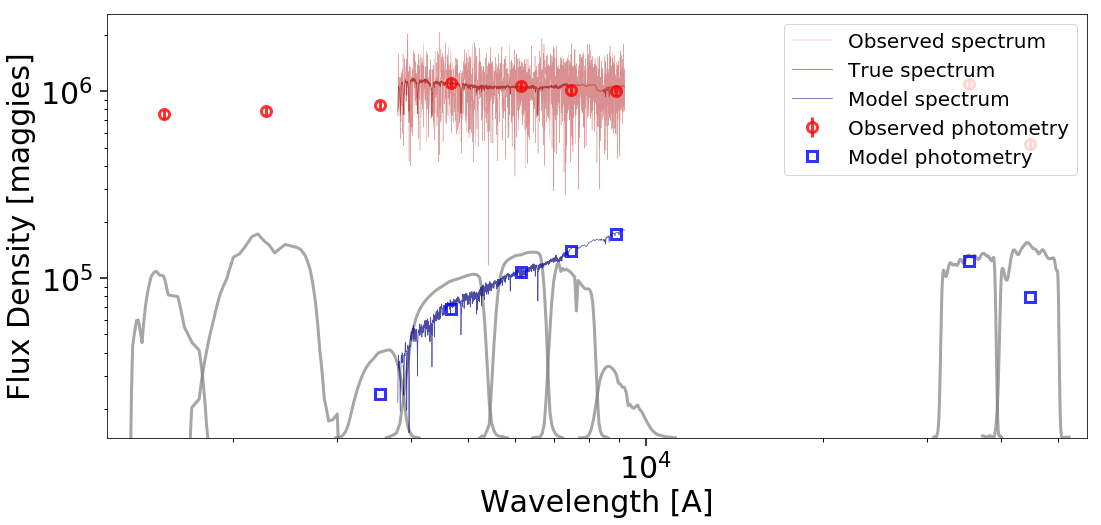

In [7]:
# spectral wavelengths
if obs['wavelength'] is not None: 
    wspec = obs['wavelength']
else:
    wspec = sps.csp.wavelengths
wphot = array([f.wave_effective for f in obs['filters']]) # photometric effective wavelengths
wphot_width = array([f.effective_width for f in obs['filters']]) # photometric effective widths

initial_theta = model.rectify_theta(model.initial_theta) # initial parameters
mspec_init, mphot_init, mfrac_init = model.mean_model(initial_theta, obs, sps=sps) # generate model

# establish bounds
xmin, xmax = wphot.min()*0.8, wphot.max()/0.8
temp = interp(linspace(xmin,xmax,10000), wspec, mspec_init)
ymin, ymax = temp.min()*0.8, temp.max()/0.8
if obs['spectrum'] is not None:
    ymin, ymax = min(ymin, obs['spectrum'].min()*0.8), max(ymax, obs['spectrum'].max()/0.8)

# plotting 
figure(figsize=(16,8))
for i in xrange(len(wphot)):
    f = obs['filters'][i]
    w, t = f.wavelength.copy(), f.transmission.copy()
    while t.max() > 1:
        t /= 10.
    t = 0.1*(ymax-ymin)*t + ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)
if obs['spectrum'] is not None:
    loglog(wspec, obs['spectrum'], lw=0.4, color='firebrick', alpha=0.5, label='Observed spectrum', zorder=1)
loglog(wspec, obs['true_spectrum'], lw=0.7, color='firebrick', alpha=0.8, label='True spectrum', zorder=1)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], ecolor='red', marker='o', ls='', lw=3, markersize=10, 
         markerfacecolor='none', markeredgecolor='red', markeredgewidth=3, alpha=0.8, 
         label='Observed photometry', zorder=2)
loglog(wspec, mspec_init, lw=0.7, color='navy', alpha=0.7, label='Model spectrum', zorder=3)
errorbar(wphot, mphot_init, marker='s', ls='', lw=3, markersize=10,
         markerfacecolor='none', markeredgecolor='blue', markeredgewidth=3, alpha=0.8, 
         label='Model photometry', zorder=4)
xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()

## Emission Line Model

In addition to our physical (continuum) model, FSPS also predicts the nebular emission line luminosities for a number of atomic species. In addition to the continuum, Prospector has the ability to model all these lines simultaneously.

In [8]:
emline_wavelengths = sps.csp.emline_wavelengths # get wavelengths of emission lines
emline_names = loadtxt('emlines_info.dat', delimiter=',', dtype=str)[:,1]
Nlines = len(emline_names)
print c_[emline_names, emline_wavelengths]

[['Ly 923' '923.15']
 ['Ly 926' '926.25']
 ['Ly 930' '930.75']
 ['Ly 937' '937.81']
 ['Ly delta 949' '949.74']
 ['Ly gamma 972' '972.52']
 ['Ly beta 1025' '1025.73']
 ['Ly alpha 1216' '1215.67']
 ['HeII 1640' '1640.42']
 ['OIII]1661' '1661.24']
 ['OIII]1666' '1666.15']
 ['[NeIII]1815' '1812.2']
 ['[AlIII] 1855' '1854.72']
 ['[AlIII] 1863' '1862.79']
 ['[CIII]' '1906.68']
 ['[CIII]' '1908.73']
 ['NII]2141' '2142.3']
 ['[OIII]2321' '2321.66']
 ['CII]2326' '2324.21']
 ['CII]2326' '2325.4']
 ['CII]2326' '2326.11']
 ['CII]2326' '2327.64']
 ['CII]2326' '2328.83']
 ['[OII]2471' '2471.09']
 ['[AlII] 2660' '2661.15']
 ['[AlII] 2670' '2669.95']
 ['MgII 2800' '2796.35']
 ['MgII 2800' '2803.53']
 ['[ArIII]3110' '3109.98']
 ['[NeIII]3343' '3343.5']
 ['[SIII]3723' '3722.75']
 ['[OII]3726' '3727.1']
 ['[OII]3729' '3729.86']
 ['H 3798' '3798.99']
 ['H 3835' '3836.49']
 ['[NeIII]3870' '3869.86']
 ['HeI 3889' '3889.75']
 ['H 3889' '3890.17']
 ['[NeIII]3968' '3968.59']
 ['H 3970' '3971.2']
 ['[SII]4070' 

### Spectral Model

We model each emission line $i$ as a scaled **Normal (i.e. Gaussian) distribution** characterized by its mean $\mu_i$ (i.e. central wavelength), standard deviation $\sigma_i$ (i.e. velocity dispersion), and amplitude $L_i$ (i.e. line luminosity) over a wavelength vector $\boldsymbol{\lambda}$ such that

$$ \mathbf{S}_{\textrm{em}}(\boldsymbol{\phi}_i = \lbrace \mu_i, \sigma_i, L_i \rbrace \,|\, \boldsymbol{\theta}) = \frac{\boldsymbol{\lambda}^2}{c} L_i(\boldsymbol{\theta}) \, \mathcal{N}(\boldsymbol{\lambda} \, | \, \mu_i, \sigma_i^2) \quad  , \quad
\mathcal{N}(\boldsymbol{\lambda} \,|\, \mu_i, \sigma_i^2) \equiv \frac{1}{\sqrt{2\pi}\sigma} \exp\left[-\frac{1}{2} \frac{(\boldsymbol{\lambda} - \mu_i)^2}{\sigma_i^2} \right] $$ 

where the $\boldsymbol{\lambda}^2/c$ term converts from flux density per wavelength to per frequency, $\sigma_i = \lambda_i \frac{v_i}{c}$, and our line luminosity $L_i(\boldsymbol{\theta}$ is a function of our input physical parameters. Our full spectral model is thus

$$ 
\mathbf{S}_{\textrm{em}}(\boldsymbol{\phi} 
= \lbrace \dots, \boldsymbol{\phi}_i, \dots \rbrace \,|\, \boldsymbol{\theta}) = \frac{\boldsymbol{\lambda}^2}{c} \sum_i \mathbf{S}_{\textrm{em}}(\boldsymbol{\phi}_i)
= \frac{\boldsymbol{\lambda}^2}{c} \sum_i L_i(\boldsymbol{\theta}) \mathcal{N}(\boldsymbol{\lambda} \,|\, \mu_i, \sigma_i^2) \quad .
$$

### Photometric Model

The photometric flux density $F_b$ in a given band $b$ with transmission $T_b(\nu)$ is defined as

$$ F_b = \frac{\int S_\nu(\nu) T_b(\nu) \, \nu^{-1} d\nu}{\int G_\nu T_b(\nu) \, \nu^{-1} d\nu} = \frac{\int S_\lambda(\lambda) T_b(\lambda) \, \lambda d\lambda}{\int G_\lambda T_b(\lambda) \, \lambda d\lambda} $$

where $w_b \equiv \left[ \int G_\lambda T_b(\lambda) \, \lambda^{-1} d\lambda \right]^{-1}$ is a constant specific to each filter and $G_\nu$ is the AB magnitude reference spectrum. The photometric flux densities for each line are thus

$$ \mathbf{F}_{\textrm{em}}(\boldsymbol{\phi}_i  \,|\, \boldsymbol{\theta}) = \left\lbrace \dots, w_b \sum_i L_i(\boldsymbol{\theta}) \int \mathcal{N}(\lambda \,|\, \mu_i, \sigma_i^2) T_b(\lambda) \, \lambda d\lambda , \dots \right\rbrace \quad .$$ 

Note that we are being slightly pedantic here because this result will be useful later!

### Model Preview

Our default model will have a velocity dispersion of 150 km/s with no shifts among our lines and the default line luminosities of our output model.

In [9]:
# initialize line parameters
mspec, mphot, mfrac = model.mean_model(theta_truth, obs, sps=sps) # initialize SPS model
emline_L = fit.get_emline_L(sps) # emline luminosity [L_sun]
emline_mu = emline_wavelengths # emline wavelengths [A]
emline_vdisp = 150e3 # emline velocity dispersion [m/s]
emline_sigma = emline_vdisp / c * emline_mu # emline wavelength dispersion [A]
phi_truth = c_[emline_mu, emline_sigma, emline_L].flatten() # (mu, sigma, L) collection
Nphi = len(phi_truth)

### SED Preview

Let's now take a look at our new model after taking into account the contribution from emission lines.

In [10]:
mspec, mphot, mfrac = fit.combined_model(theta_truth, model, obs, sps, phi=phi_truth) # add lines according to phi
obs['true_spectrum'] = mspec.copy()
obs['spectrum'] = normal(obs['true_spectrum'], obs['unc']) # jitter spectrum
obs['true_maggies'] = mphot.copy()
obs['maggies'] = normal(obs['true_maggies'], obs['maggies_unc']) # jitter

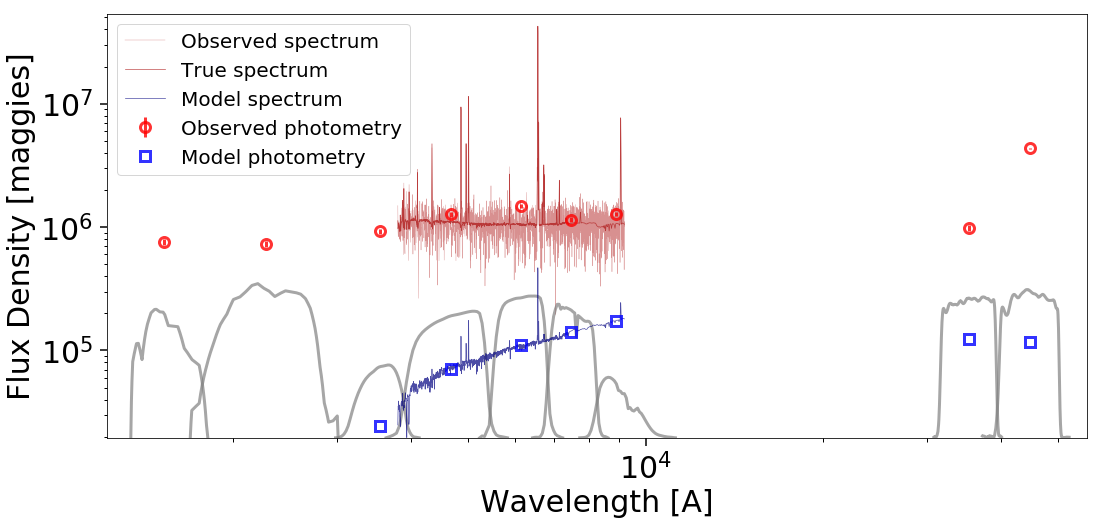

In [11]:
mspec_init, mphot_init, mfrac_init = fit.combined_model(initial_theta, model, obs, sps) # new initial spectrum

# establish bounds
xmin, xmax = wphot.min()*0.8, wphot.max()/0.8
temp = interp(linspace(xmin,xmax,10000), wspec, mspec_init)
ymin, ymax = temp.min()*0.8, temp.max()/0.8
if obs['spectrum'] is not None:
    ymin, ymax = min(ymin, obs['spectrum'].min()*0.8), max(ymax, obs['spectrum'].max()/0.8)

# plotting 
figure(figsize=(16,8))
for i in xrange(len(wphot)):
    f = obs['filters'][i]
    w, t = f.wavelength.copy(), f.transmission.copy()
    while t.max() > 1:
        t /= 10.
    t = 0.01*(ymax-ymin)*t + ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)
if obs['spectrum'] is not None:
    loglog(wspec, obs['spectrum'], lw=0.4, color='firebrick', alpha=0.5, label='Observed spectrum', zorder=1)
loglog(wspec, obs['true_spectrum'], lw=0.7, color='firebrick', alpha=0.8, label='True spectrum', zorder=1)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], ecolor='red', marker='o', ls='', lw=3, markersize=10, 
         markerfacecolor='none', markeredgecolor='red', markeredgewidth=3, alpha=0.8, 
         label='Observed photometry', zorder=2)
loglog(wspec, mspec_init, lw=0.7, color='navy', alpha=0.7, label='Model spectrum', zorder=3)
errorbar(wphot, mphot_init, marker='s', ls='', lw=3, markersize=10,
         markerfacecolor='none', markeredgecolor='blue', markeredgewidth=3, alpha=0.8, 
         label='Model photometry', zorder=4)
xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()

# Fitting the Baseline Model

Our goal with Prospector is to sample not only the underlying parameters $\boldsymbol{\theta}$ that comprise our physical galaxy model, but also the "auxiliary" parameters $\boldsymbol{\phi}$ that comprise our emission lines. Before we jump right to our combined statistical model for $\lbrace \boldsymbol{\theta}, \boldsymbol{\phi} \rbrace$, however, we want outline our model for each component **separately** to build some intuition.

**In this section, we'll focus on our physical parameters $\boldsymbol{\theta}$. Furthermore, to illustrate the information content contained within just the spectrum itself, we'll turn off our emission lines for this run.**

In [12]:
mspec, mphot, mfrac = fit.combined_model(theta_truth, model, obs, sps, add_emline=False) # no lines
obs['true_spectrum'] = mspec.copy()
obs['spectrum'] = normal(obs['true_spectrum'], obs['unc']) # jitter spectrum
obs['true_maggies'] = mphot.copy()
obs['maggies'] = normal(obs['true_maggies'], obs['maggies_unc']) # jitter

## Statistical Model

We take our spectro-photometric observations $\mathbf{\hat{S}}$ and $\mathbf{\hat{F}}$ to be multivariate normally distributed with covariances $\mathbf{\hat{C}_\hat{S}}$ and $\mathbf{\hat{C}_\hat{F}}$. For a given prior $P(\boldsymbol{\theta})$, our posterior is is then

$$ 
P(\boldsymbol{\theta} \,|\, \mathbf{\hat{S}}, \mathbf{\hat{F}}) 
\propto P(\mathbf{\hat{S}}, \mathbf{\hat{F}} \,|\, \boldsymbol{\theta}) \, P(\boldsymbol{\theta}) 
= \mathcal{N}\left[\Delta\mathbf{\hat{S}}(\boldsymbol{\theta}) \:|\: \mathbf{0}, \mathbf{\hat{C}_\hat{S}} \right] \, \mathcal{N}\left[\Delta\mathbf{\hat{F}}(\boldsymbol{\theta}) \:|\: \mathbf{0}, \mathbf{\hat{C}_\hat{F}} \right] 
\, P(\boldsymbol{\theta}) 
$$

where $\Delta\mathbf{\hat{S}}(\boldsymbol{\theta}) \equiv \mathbf{S}(\boldsymbol{\theta}) - \mathbf{\hat{S}}$ and $\Delta\mathbf{\hat{F}}(\boldsymbol{\theta}) \equiv \mathbf{F}(\boldsymbol{\theta}) - \mathbf{\hat{F}}$. **Again, while ideally our model will include both continuum and emission features, in this section only the continuum features are considered.**

The corresponding log-posterior is then

$$ 
\ln P(\mathbf{\hat{S}}, \mathbf{\hat{F}} \,|\, \boldsymbol{\theta}) 
= \left[ -\frac{1}{2}\Delta\mathbf{\hat{F}}(\boldsymbol{\theta})^T \mathbf{\hat{C}_\hat{F}}^{-1} \Delta\mathbf{\hat{F}}(\boldsymbol{\theta}) + Z_{\mathbf{\hat{F}}} \right] 
+ \left[ -\frac{1}{2}\Delta\mathbf{\hat{S}}(\boldsymbol{\theta})^T \mathbf{\hat{C}_\hat{S}}^{-1} \Delta\mathbf{\hat{S}}(\boldsymbol{\theta}) + Z_{\mathbf{\hat{S}}} \right] 
+ \ln P(\boldsymbol{\theta}) 
$$

where 

$$ 
Z_{\mathbf{\hat{S}}} = -\frac{1}{2} ( N_S \ln 2\pi + \ln|\mathbf{\hat{C}_\hat{S}}| ) \quad , \quad 
Z_{\mathbf{\hat{F}}} = -\frac{1}{2} ( N_F \ln 2\pi + \ln|\mathbf{\hat{C}_\hat{F}}| )
$$ 

are associated normalization constants where $|\bullet|$ is the determinant and $N_S$ and $N_F$ are the number of spectral and photometric data points, respectively.

In this demo, our covariances are diagonal (i.e. our points are all sampled independently from each other). This allows us to simply write our posterior as

$$
\ln P(\boldsymbol{\theta} \,|\, \mathbf{\hat{S}}, \mathbf{\hat{F}}) = -\frac{1}{2}\left[\chi^2_\mathbf{\hat{S}} + \chi^2_\mathbf{\hat{F}} \right] + Z_\mathbf{\hat{S}} + Z_\mathbf{\hat{F}} + \ln P(\boldsymbol{\theta})
$$

where $\chi^2$ is the usual chi-square function.

Using individual components of this model imported from Prospector, we define our log-posterior below.

In [13]:
from prospect.likelihood import lnlike_spec, lnlike_phot, write_log

def lnprobfn(theta):
    """
    Given a parameter vector and a dictionary of observational data and a model object, 
    return the ln of the posterior. This requires that an sps object (and if using spectra 
    and gaussian processes, a GP object) be instantiated.
    """

    lnp_prior = model.prior_product(theta)
    if isfinite(lnp_prior):
        
        # Generate mean model
        t1 = time.time()
        try:
            mu, phot, x = fit.combined_model(theta, model, obs, sps, add_emline=False) # lines disabled
        except(ValueError):
            return -np.infty
        d1 = time.time() - t1

        # Noise modeling
        if spec_noise is not None:
            spec_noise.update(**model.params)
        if phot_noise is not None:
            phot_noise.update(**model.params)
        vectors = {'spec': mu, 'unc': obs['unc'],
                   'sed': model._spec, 'cal': model._speccal,
                   'phot': phot, 'maggies_unc': obs['maggies_unc']}

        # Calculate log-likelihoods
        t2 = time.time()
        lnp_spec = lnlike_spec(mu, obs=obs, spec_noise=spec_noise, **vectors)
        lnp_phot = lnlike_phot(phot, obs=obs, phot_noise=phot_noise, **vectors)
        d2 = time.time() - t2
        if verbose:
            write_log(theta, lnp_prior, lnp_spec, lnp_phot, d1, d2)

        return lnp_prior + lnp_phot + lnp_spec
    
    else:
        return -np.infty

## Burning in: Optimization

We can attempt to initialize our model reasonably close to the true result by using numerical minimization routines to find an estimate of the **maximum a posteriori (MAP)**.

In [14]:
from scipy.optimize import minimize

In [15]:
def neglnprobfn(theta):
    """Negative of lnprobfn for minimization, and also handles passing in
    keyword arguments which can only be postional arguments when using scipy
    minimize.
    """
    return -lnprobfn(theta)

# start minimization
verbose = False
sys.stdout = fnull
min_method = 'Nelder-Mead'
ts = time.time()
min_results = minimize(neglnprobfn, initial_theta, method=min_method)
pdur = time.time() - ts
sys.stdout = fout

# output results
print('done {0} in {1}s'.format(min_method, pdur))
print('best {0} lnp: {1}'.format(min_method, -min_results.fun))
print('true lnp: {0}'.format(lnprobfn(theta_truth)))
print('best {0} guess: {1}'.format(min_method, min_results.x))
print('truth: {0}'.format(theta_truth))

done Nelder-Mead in 13.125674963s
best Nelder-Mead lnp: -27472.935243
true lnp: -27475.2917321
best Nelder-Mead guess: [  1.13279009e+07  -6.43077817e-01   9.97543534e+01   6.12177564e-01
   2.98282971e-01]
truth: [  1.00000000e+07  -5.00000000e-01   8.00000000e+01   5.00000000e-01
   3.00000000e-01]


Note that creating a new model with FSPS is somewhat time-intensive, but once the relevant model(s) have been loaded they are subsequently stored in cache so similar models can be generated much more quickly.

Now let's see how our model looks.

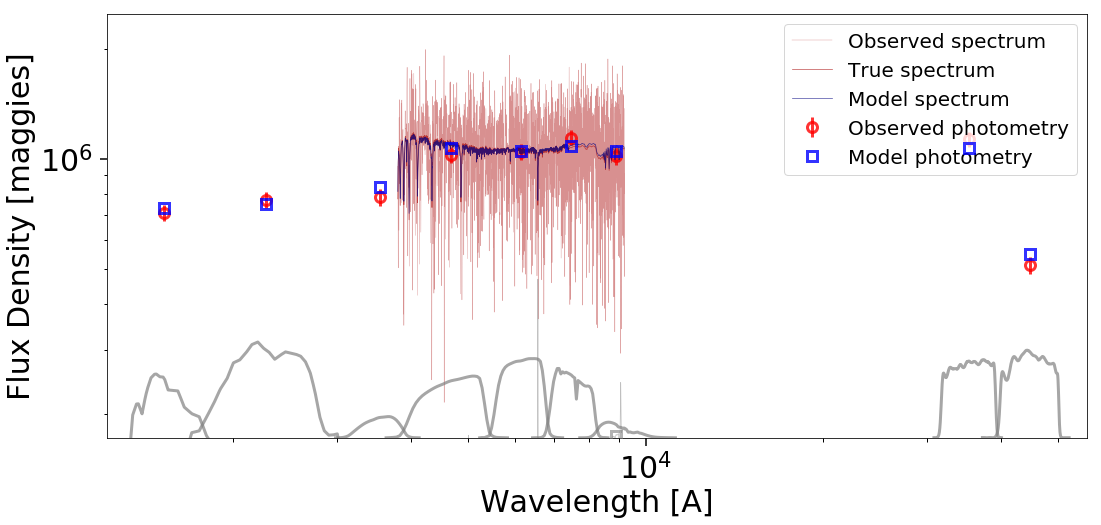

In [16]:
theta = model.rectify_theta(min_results.x) # initial parameters
mspec, mphot, mfrac = fit.combined_model(theta, model, obs, sps, add_emline=False) # generate model

# establish bounds
xmin, xmax = wphot.min()*0.8, wphot.max()/0.8
temp = interp(linspace(xmin,xmax,10000), wspec, mspec)
ymin, ymax = temp.min()*0.8, temp.max()/0.8
if obs['spectrum'] is not None:
    ymin, ymax = min(ymin, obs['spectrum'].min()*0.8), max(ymax, obs['spectrum'].max()/0.8)

# plotting 
figure(figsize=(16,8))
for i in xrange(len(wphot)):
    f = obs['filters'][i]
    w, t = f.wavelength.copy(), f.transmission.copy()
    while t.max() > 1:
        t /= 10.
    t = 0.1*(ymax-ymin)*t + ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)
if obs['spectrum'] is not None:
    loglog(wspec, obs['spectrum'], lw=0.4, color='firebrick', alpha=0.5, label='Observed spectrum', zorder=1)
loglog(wspec, obs['true_spectrum'], lw=0.7, color='firebrick', alpha=0.8, label='True spectrum', zorder=1)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], ecolor='red', marker='o', ls='', lw=3, markersize=10, 
         markerfacecolor='none', markeredgecolor='red', markeredgewidth=3, alpha=0.8, 
         label='Observed photometry', zorder=2)
loglog(wspec, mspec_init, lw=0.7, color='gray', alpha=0.5, zorder=3)
errorbar(wphot, mphot_init, marker='s', ls='', lw=3, markersize=10,
         markerfacecolor='none', markeredgecolor='gray', markeredgewidth=3, alpha=0.6, zorder=4)
loglog(wspec, mspec, lw=0.7, color='navy', alpha=0.7, label='Model spectrum', zorder=5)
errorbar(wphot, mphot, marker='s', ls='', lw=3, markersize=10,
         markerfacecolor='none', markeredgecolor='blue', markeredgewidth=3, alpha=0.8, 
         label='Model photometry', zorder=6)
xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()

## Exploring the Posterior

Now that we're burned in, we can begin sampling from the posterior using **Markov Chain Monte Carlo** (MCMC). We'll use the **affine-invariant ensemble MCMC sampler** outlined in Goodman & Weare (2010) and popularized by Foreman-Mackey et al. (2013) as **emcee**.

Before we get into how emcee works, however, let's quickly review the basics of MCMC.

### Basics: MCMC

We evolve an individual chain in an MCMC sampler in three steps:
1. Based on the chain's current position $\mathbf{X}^{(t)}$ at iteration $t$, propose a new position $\mathbf{X}^{(t+1)}$ drawn from a **proposal distribution** (i.e. neighborhood function) $\mathbf{X}^{(t+1)} \sim g(\mathbf{X}^{(t+1)} = \mathbf{x}^{(t+1)} \,|\, \mathbf{X}^{(t)})$.
2. Compute the posterior $P(\mathbf{X}^{(t+1)} \,|\, \mathbf{D})$ given our data $\mathbf{D}$ at the proposed position $\mathbf{X}^{(t+1)}$.
3. Accept the proposed state according to a **Metropolis update** via $A(\mathbf{X}^{(t+1)} \,|\, \mathbf{X}^{(t)}) = \min \left\lbrace 1, \frac{g(\mathbf{X}^{(t)} \,|\, \mathbf{X}^{(t+1)})}{g(\mathbf{X}^{(t+1)} \,|\, \mathbf{X}^{(t)})} \frac{P(\mathbf{X}^{(t+1)} \,|\, \mathbf{D})}{P(\mathbf{X}^{(t)} \,|\, \mathbf{D})} \right\rbrace$.

Typically, a sampler will run $n$ chains where the proposal distribution for each chain $i$ at iteration $t$ is **additive** and centered on $\mathbf{X}_i^{(t)}$ such that 

$$ 
\mathbf{X}_i^{(t+1)} = \mathbf{X}_i^{(t)} + \mathbf{Z}_i \quad , \quad 
\mathbf{Z}_i \sim g_i(\mathbf{Z}_i = \mathbf{z})
$$ 

where the proposal $g_i(\mathbf{z})$ is symmetric. A common choice is a multivariate Normal such that $g_i(\mathbf{z}) = \mathcal{N}(\mathbf{z} \,|\, \mathbf{0}, \mathbf{C}_i)$. The resulting proposal distribution for $g(\mathbf{X}^{(t+1)} \,|\, \mathbf{X}^{(t)})$ is then symmetric between $\mathbf{X}_i^{(t)}$ and $\mathbf{X}_i^{(t+1)}$, so the Metropolis criterion simply reduces to $A(\mathbf{X}_i^{(t+1)} \,|\, \mathbf{X}_i^{(t)}) = \min \left\lbrace 1, \frac{P(\mathbf{X}_i^{(t+1)} \,|\, \mathbf{D})}{P(\mathbf{X}_i^{(t)} \,|\, \mathbf{D})} \right\rbrace$.

### Disgression: Compound Transitions

In addition to the simple picture defined above, it is also useful to view the above chain as a number of **compound transitions** from our original state $\mathbf{X}^{(t)}$ to our final state $\mathbf{X}^{(t+1)}$. For instance, in the above case, we can consider the compound transition from $\mathbf{X}^{(t)} \rightarrow \mathbf{X}^{(t)}$ (the identity transition) and then from $\mathbf{X}^{(t)} \rightarrow \mathbf{X}^{(t+1)}$ via $\mathbf{Z}$. 

In the case where $\mathbf{Z} \sim \mathcal{N}(\mathbf{z} \,|\, \mathbf{0}, \mathbf{C})$, we can go one step further by noting that the sum of a bunch of multivariate normal random variables is itself multivariate normal such that

$$ \mathbf{Z} \equiv \sum_\epsilon \mathbf{Z}_j \sim \mathcal{N}(\mathbf{z} \,|\, \mathbf{0}, \mathbf{C} \equiv \sum_j \mathbf{C}_\epsilon) \quad . $$

The transition probability between three consecutive intermediate states in this process $\mathbf{X}^{(1)} \rightarrow \mathbf{X}^{(2)} \rightarrow \mathbf{X}^{(3)}$ is simply 

$$ P(\mathbf{X}^{(1)} \rightarrow \mathbf{X}^{(2)} \rightarrow \mathbf{X}^{(3)}) 
= P(\mathbf{X}^{(1)} \rightarrow \mathbf{X}^{(2)}) \, P(\mathbf{X}^{(2)} \rightarrow \mathbf{X}^{(3)}) 
= \frac{P(\mathbf{X}_i^{(2)})}{P(\mathbf{X}_i^{(1)})} \frac{P(\mathbf{X}_i^{(3)})}{P(\mathbf{X}_i^{(2)})} 
= \frac{P(\mathbf{X}_i^{(3)})}{P(\mathbf{X}_i^{(1)})} \quad .
$$

This can be directly generalized to an arbitrary number of intermediate transitions between our initial state $\mathbf{X}^{(t)}$ and our final proposed state $\mathbf{X}^{(t+1)}$. In other words, transitioning directly from $\mathbf{X}^{(t)} \rightarrow \mathbf{X}^{(t+1)}$ using a single proposal is **fundamentally equivalent** (and indistinguishable) from the same transition computed after an arbitrary number of compound proposals. This intuition is crucial for understanding our joint sampler later in the notebook.

### Basics: emcee

The proposal distribution for the affine-invariant ensemble (i.e. particle) sampler differs from that of the typical proposal discussed above in three ways:
1. The proposal for a **walker** (emcee's version of a chain) $i$ at $\mathbf{X_i}$ is centered on the position of a randomly selected walker $j \neq i$ located at position $\mathbf{X}_j$.
2. The breadth of the proposal is based on the distance between the two walkers $\Delta \mathbf{X}_{ij} \equiv \mathbf{X}_i - \mathbf{X}_j$.
3. The proposal is **multiplicative** rather than additive.

This allows it to adapt to features in the space in a way that is robust to linear transformations.

More formally, emcee's affine-invariant update is a **stretch move** where the new position $\mathbf{X}_i(t+1)$ is proposed via

$$ \mathbf{X}_i^{(t+1)} = \mathbf{X}_j^{(t)} + Z \, \Delta \mathbf{X}_{ij}^{(t)} $$

where $\Delta \mathbf{X}_{ij} \equiv \mathbf{X}_i - \mathbf{X}_j$ is the vector spanning the two walkers and 

$$ Z \sim g(Z = z) \quad , \quad g(z) \equiv z^{-1/2} \: \textrm{for} \: z \in \left[a^{-1}, a \right] \: \textrm{and zero otherwise} $$

is drawn from our stretch proposal, where $a$ is most often set to 2. In other words, we make a compound transition from $\mathbf{X}_i^{(t)} \rightarrow \mathbf{X}_j^{(t)} \rightarrow \mathbf{X}_i^{(t+1)}$.

It is important to note that the resulting proposal is *not* symmetric between $\mathbf{X}_i^{(t)}$ and $\mathbf{X}_i^{(t+1)}$ due to the differences in the relative vector span $\Delta \mathbf{X}_{ij}^{(t)}$ and $\Delta \mathbf{X}_{ij}^{(t+1)}$. The modified Metropolis update can, however, be shown to be

$$ A(\mathbf{X}_i^{(t+1)} \,|\, \mathbf{X}_i^{(t)}) = \min \left\lbrace 1, Z^{N-1} \frac{P(\mathbf{X}_i^{(t+1)} \,|\, \mathbf{D})}{P(\mathbf{X}_i^{(t)} \,|\, \mathbf{D})} \right\rbrace \quad . $$

Intuitively, we can understand the prefactor by noting that the particular functional form for $g(z)$ gives an update proportional to $z^{-1/2}$ that shows up in both parts of our proposal, giving us a constant prefactor of $Z^{-1}$. However, since $g(z^{-1}) = z g(z)$ and we've applied our stretch factor $Z$ in $N$ dimensions, we pick up a factor of $Z^{N}$. Functionally, this just means that we reward large stretch moves (which are more unlikely) and penalize small stretch moves (which are more likely).

## Sampling the Posterior

Our implementation of emcee is contained in a series of functions stored in *fit_utils*. This is mostly identical to the version discussed above except that we utilize **simulated annealing** to improve convergence to the posterior during burn-in.

Let's initialize our group of walkers. We'll utilize a Gaussian ball centered on the MAP estimate we derived earlier with a standard deviation set to 10% the total range spanned by our priors.

In [17]:
Nwalkers = 128 # number of walkers
pos_init = empty((Nwalkers, Ntheta), dtype='float') # initial positions
lnp_init = empty(Nwalkers) # initial lnPs

for i in xrange(Nwalkers):
    while True:
        pos = normal(min_results.x, scale=diff(model.theta_bounds()).flatten()/10.) # propose position
        inbounds = prod([model.theta_bounds()[j][0] <= pos[j] <= model.theta_bounds()[j][1] 
                         for j in xrange(Ntheta)]) # check if position is in bounds
        if inbounds: # if not out of bounds, accept proposed starting point
            sys.stdout.write(str(i)+' ')
            pos_init[i], lnp_init[i] = pos, lnprobfn(pos)
            break

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 

Now that everything's initialized, let's start sampling!

In [18]:
sys.stdout = fnull

Nburn, Niter = 128, 512 # number of burn-in and sampling iterations
T_max = 25. # starting (maximum) temperature

tstart = time.time()
emcee_sampler = fit.sample_emcee(Niter, pos_init, lnp_init, lnprobfn, Nburn, T_max) # run emcee
pos_chain, lnp_chain, pos_burn, lnp_burn = emcee_sampler # re-assign outputs
edur = time.time() - tstart

sys.stdout = fout

print('done emcee in {0}s'.format(edur))

fit_utils.py:131: RuntimeWarning: overflow encountered in exp
  return np.exp(lnp_prop - lnp_old) * Z**(Ndim-1) # return transition probability
10 20 30 40 50 60 70 80 90 100 110 120 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 

done emcee in 1297.50211883s


## Visualizing Our Results

There are a few ways to visualize our outputs. The easiest is just looking at the time evolution of our chains (their **traces**).

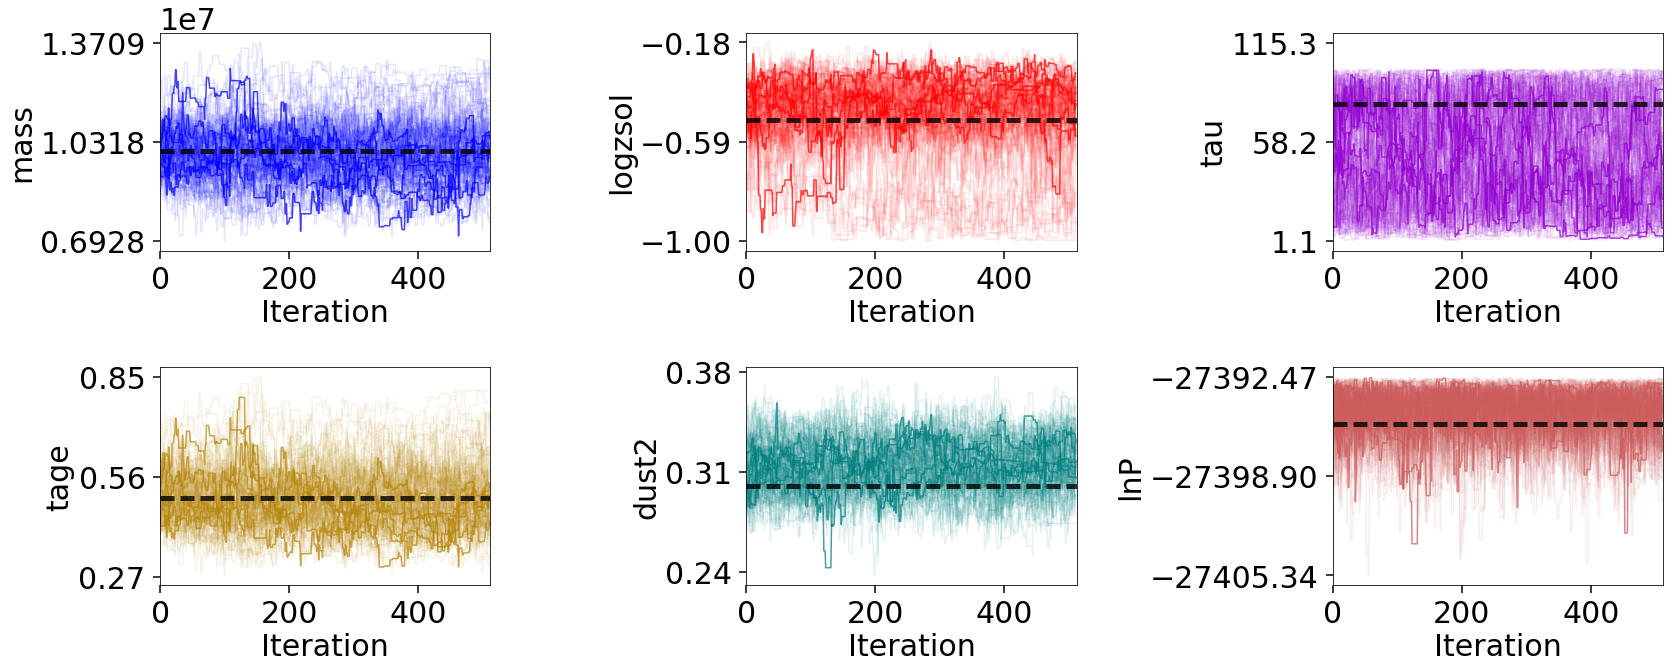

In [19]:
# plot traces
Nburnin, Nthin = 0, 1 # number of samples to burn, thin by every Nth sample
varcolors = ['blue', 'red', 'darkviolet', 'darkgoldenrod', 'teal']
varnames = model.free_params
hwalkers = choice(Nwalkers, replace=False, size=5) # random selection of walkers to highlight to gauge behavior
figure(figsize=(24,10))
for i in xrange(Ntheta):
    subplot(2,3,i+1)
    samples = pos_chain[Nburnin::Nthin,:,i] # grab samples
    plot(arange(Nburnin, Niter, Nthin), samples, lw=1.5, alpha=0.1, color=varcolors[i]) # all walkers
    plot(arange(Nburnin, Niter, Nthin), samples[:,hwalkers], lw=1.5, alpha=0.7, color=varcolors[i]) # highlighted
    hlines(theta_truth[i], Nburnin, Niter, colors='black', lw=5, alpha=0.8, linestyle='--', zorder=10) # truth
    ymin, ymax = samples.min(), samples.max()
    yticks(linspace(ymin, ymax, 3).round(2))
    xlabel('Iteration')
    xlim([Nburnin, Niter])
    ylabel(varnames[i])
    tight_layout()
subplot(2,3,6)
samples = lnp_chain[Nburnin::Nthin]
plot(arange(Nburnin, Niter, Nthin), samples, lw=1.5, alpha=0.1, color='indianred')
plot(arange(Nburnin, Niter, Nthin), samples[:,hwalkers], lw=1.5, alpha=0.7, color='indianred')
hlines(lnprobfn(theta_truth), Nburnin, Niter, colors='black', lw=5, alpha=0.8, linestyle='--', zorder=10)
ymin, ymax = samples.min(), samples.max()
yticks(linspace(ymin, ymax, 3).round(2))
xlabel('Iteration')
xlim([Nburnin, Niter])
ylabel('lnP')
tight_layout()

Another approach is to take a look at the 2-D marginal distributions, commonly shown as a **corner plot**.

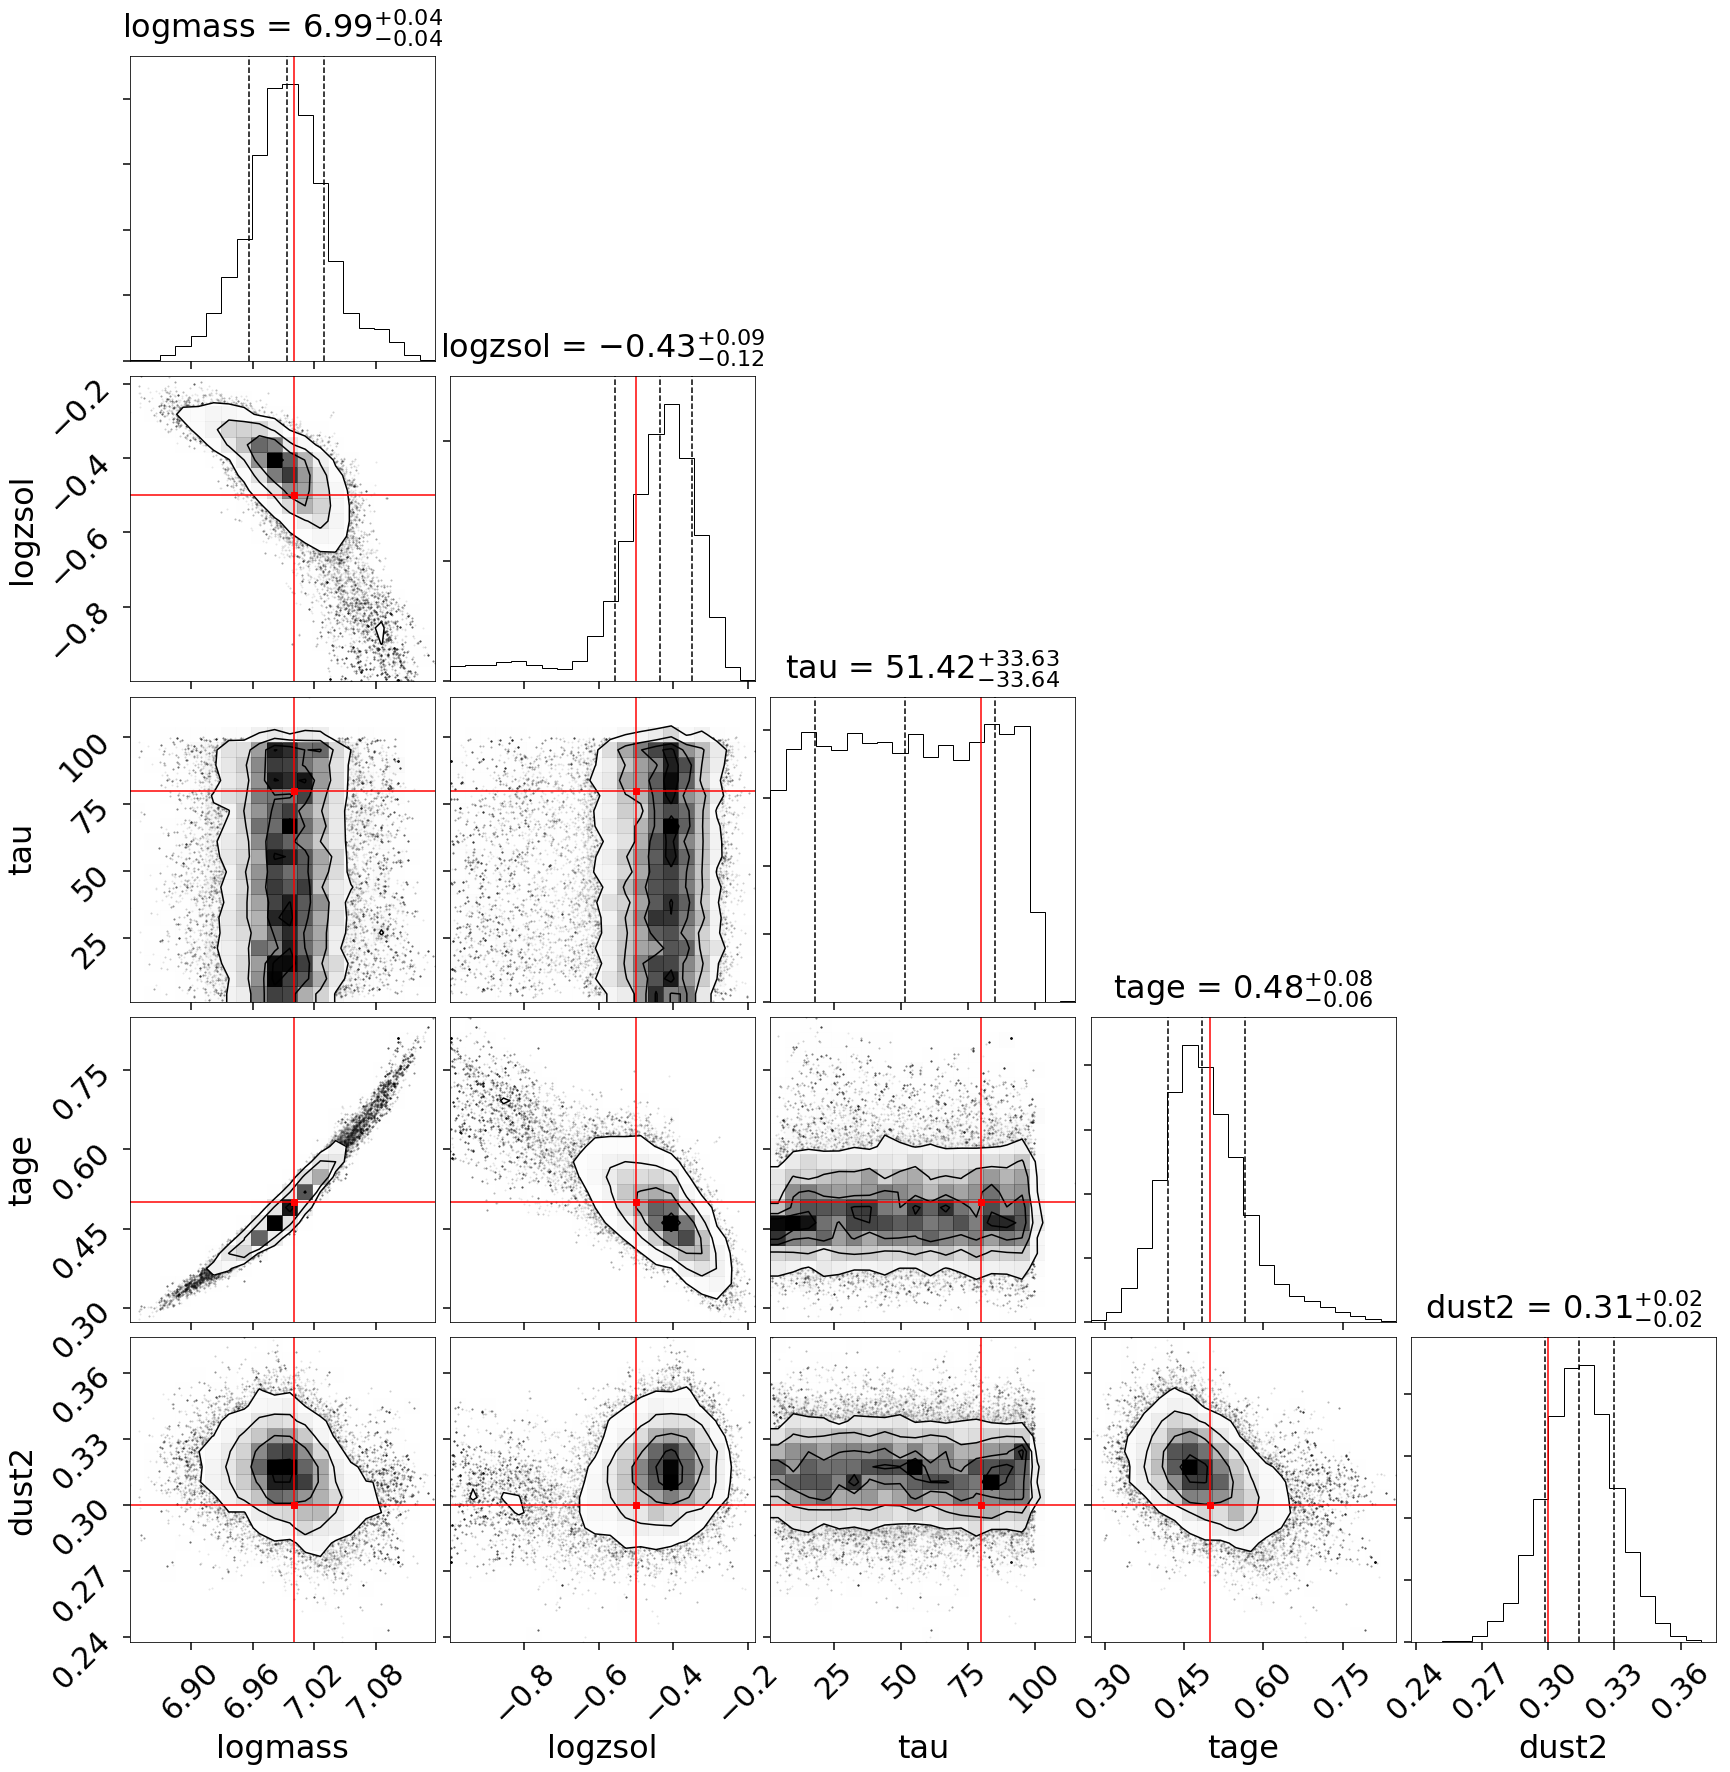

In [20]:
flatchain = pos_chain[Nburnin::Nthin].T.reshape(5,-1).T # flatten chain to 1-D
theta_truth = array([run_params[i] for i in ['mass','logzsol','tau','tage','dust2']])
varnames[0], theta_truth[0], flatchain[:,0] = 'logmass', log10(theta_truth[0]), log10(flatchain[:,0]) # logmass

# corner plot
fig = corner(flatchain, quantiles=[.16, .50, .84], labels=varnames, label_kwargs={'fontsize': 32}, 
             truths=theta_truth, truth_color='red', show_titles=True, title_kwargs={'y': 1.04, 'fontsize': 32}, 
             fig=subplots(5,5,figsize=(25,25))[0])

Finally, it's always good to check a few random models drawn from our chain. A random sampler is plotted below

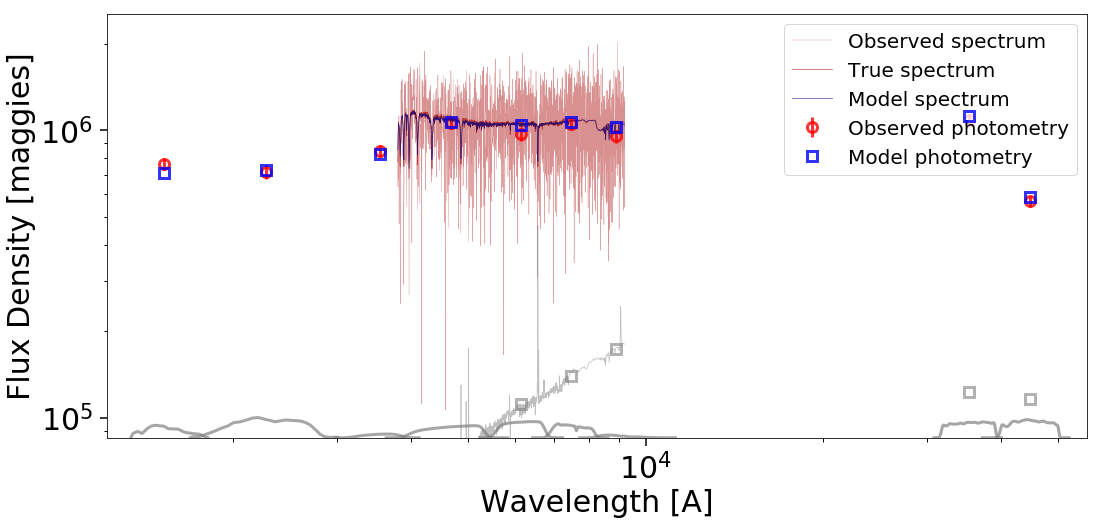

In [21]:
theta = pos_chain[randint(Niter), randint(Nwalkers)] # random parameters
mspec, mphot, mfrac = fit.combined_model(theta, model, obs, sps, add_emline=False) # generate model

# establish bounds
xmin, xmax = wphot.min()*0.8, wphot.max()/0.8
temp = interp(linspace(xmin,xmax,10000), wspec, mspec)
ymin, ymax = temp.min()*0.8, temp.max()/0.8
if obs['spectrum'] is not None:
    ymin, ymax = min(ymin, obs['spectrum'].min()*0.8), max(ymax, obs['spectrum'].max()/0.8)

# plotting 
figure(figsize=(16,8))
for i in xrange(len(wphot)):
    f = obs['filters'][i]
    w, t = f.wavelength.copy(), f.transmission.copy()
    while t.max() > 1:
        t /= 10.
    t = 0.01*(ymax-ymin)*t + ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)
if obs['spectrum'] is not None:
    loglog(wspec, obs['spectrum'], lw=0.4, color='firebrick', alpha=0.5, label='Observed spectrum', zorder=1)
loglog(wspec, obs['true_spectrum'], lw=0.7, color='firebrick', alpha=0.8, label='True spectrum', zorder=1)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], ecolor='red', marker='o', ls='', lw=3, markersize=10, 
         markerfacecolor='none', markeredgecolor='red', markeredgewidth=3, alpha=0.8, 
         label='Observed photometry', zorder=2)
loglog(wspec, mspec_init, lw=0.7, color='gray', alpha=0.5, zorder=3)
errorbar(wphot, mphot_init, marker='s', ls='', lw=3, markersize=10,
         markerfacecolor='none', markeredgecolor='gray', markeredgewidth=3, alpha=0.6, zorder=4)
loglog(wspec, mspec, lw=0.7, color='navy', alpha=0.7, label='Model spectrum', zorder=5)
errorbar(wphot, mphot, marker='s', ls='', lw=3, markersize=10,
         markerfacecolor='none', markeredgecolor='blue', markeredgewidth=3, alpha=0.8, 
         label='Model photometry', zorder=6)
xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()

## Saving Our Results

Now that we're finished, we dump our results into a pickle file to examine later. 

In [22]:
outroot = "{0}_{1}_cont".format(run_params['outfile'], int(time.time()))
pickle.dump([run_params, model, obs, emcee_sampler, min_results], open(outroot, "wb"))

# Fitting the Emission Line Model

**In this section, we'll focus on our line parameters $\boldsymbol{\phi}$. To illustrate the general procedure, we'll just fit $\lbrace \mu_i, \sigma_i, L_i \rbrace$ directly for a continuum-normalized emission line spectrum.**

In [12]:
# initialize new data
mspec_cont, mphot_cont, mfrac = fit.combined_model(theta_truth, model, obs, sps, add_emline=False) # continuum
mspec, mphot, mfrac = fit.combined_model(theta_truth, model, obs, sps, phi=phi_truth) # w/ lines
espec, ephot = fit.line_model(phi_truth, sps.csp.wavelengths, obs)
obs['true_spectrum'] = mspec.copy()
obs['spectrum'] = normal(obs['true_spectrum'], obs['unc']) # jitter spectrum
obs['true_maggies'] = mphot.copy()
obs['maggies'] = normal(obs['true_maggies'], obs['maggies_unc']) # jitter

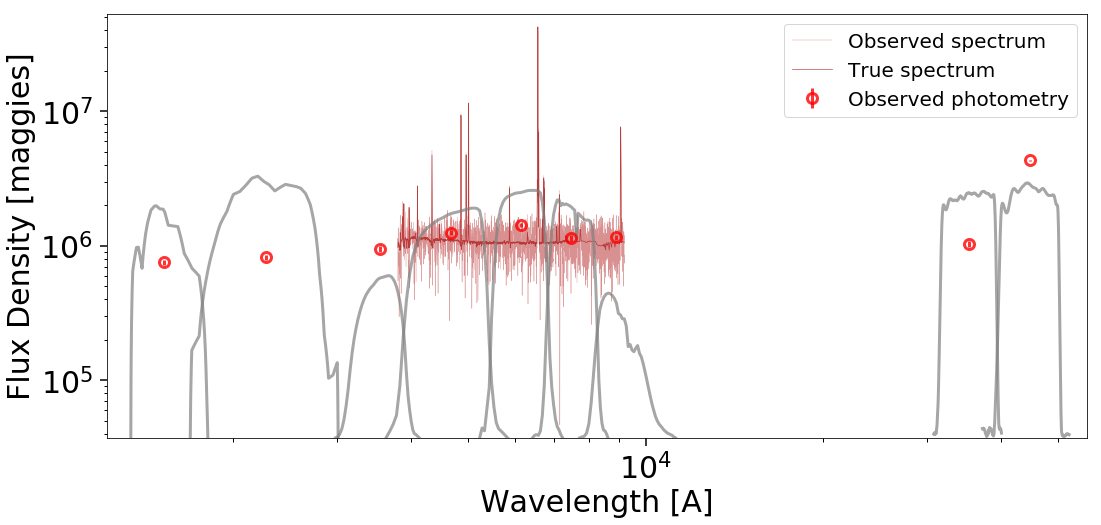

In [13]:
# establish bounds
xmin, xmax = wphot.min()*0.8, wphot.max()/0.8
temp = interp(linspace(xmin,xmax,10000), wspec, mspec)
ymin, ymax = temp.min()*0.8, temp.max()/0.8
if obs['spectrum'] is not None:
    ymin, ymax = min(ymin, obs['spectrum'].min()*0.8), max(ymax, obs['spectrum'].max()/0.8)

# plotting 
figure(figsize=(16,8))
for i in xrange(len(wphot)):
    f = obs['filters'][i]
    w, t = f.wavelength.copy(), f.transmission.copy()
    while t.max() > 1:
        t /= 10.
    t = 0.1*(ymax-ymin)*t + ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)
if obs['spectrum'] is not None:
    loglog(wspec, obs['spectrum'], lw=0.4, color='firebrick', alpha=0.5, label='Observed spectrum', zorder=1)
loglog(wspec, obs['true_spectrum'], lw=0.7, color='firebrick', alpha=0.8, label='True spectrum', zorder=1)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], ecolor='red', marker='o', ls='', lw=3, markersize=10, 
         markerfacecolor='none', markeredgecolor='red', markeredgewidth=3, alpha=0.8, 
         label='Observed photometry', zorder=2)
xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()

## Statistical Model

The core of our statistical model is identical to the baseline case, except now our model is a function of $\boldsymbol{\phi}$ only. **Again, we have suppressed the dependence of $L_i$ on $\boldsymbol{\theta}$ to make the parameters more independent.**

We take our prior over $\boldsymbol{\phi}$ to be multivariate normal with mean $\mu_{\boldsymbol{\phi}}$ and covariance $\mathbf{C}_{\boldsymbol{\phi}}$. We take our covariance to be diagnoal, and set the corresponding/mean standard deviation among each of our parameters as follows:
- $\mu_{\mu_i} = \lambda_i$, $\sigma_{\mu_i} = \lambda_i \frac{v_{\textrm{line}}}{c}$: our lines are at rest with respect to the galaxy, and can shift around by $v_{\textrm{line}}$, where we take $v_{\textrm{line}} = 50$ km/s.
- $\mu_{\sigma_i} = \lambda_i \frac{v_{\textrm{disp}}}{c}$, $\sigma_{\sigma_i} = \lambda_i \frac{v_{\textrm{broad}}}{c}$: the velocity dispersion of our lines is $v_{\textrm{disp}} \pm v_{\textrm{disp}} = 200 \pm 100$ km/s.
- $ \mu_{L_i} = L_i(\boldsymbol{\theta})$, $\sigma_{L_i} = 0.2 \mu_{L_i}$: the amplitude of our lines is centered on the predicted model value but can be scaled by $\pm 20\%$.

Since this portion of the notebook is merely illustrative, we'll ignore all the associated constants in our posterior.

In [14]:
# define prior
emline_L = fit.get_emline_L(sps) # emline luminosity [L_sun]
emline_mu = emline_wavelengths # emline wavelengths [A]
emline_sigma = 200e3/c * emline_mu # emline wavelength dispersion [A]
mean_phi = c_[emline_mu, emline_sigma, emline_L].flatten() # prior mean
std_phi = c_[emline_mu * 50e3/c, emline_mu * 100e3/c, 0.2 * emline_L].flatten() # prior covariance

def lnemlinepriorfn(phi):
    chi2 = sum(square((phi - mean_phi) / std_phi))
    return -0.5*chi2

def lnemlinelikefn(phi):
    es, ep = fit.line_model(phi, sps.csp.wavelengths, obs)
    chi2_s = sum(square((es - espec) / obs['unc']))
    chi2_p = sum(square((ep - ephot) / obs['maggies_unc']))
    return -0.5*(chi2_s + chi2_p)

def lnemlineprobfn(phi):
    return lnemlinelikefn(phi) + lnemlinepriorfn(phi)

## Exploring the Posterior

There are 128 lines in our model with a total of 384 parameters! This is quite a challenge for most optimization algorithms, never mind standard MCMC methods. Even emcee, with its adaptive ensemble sampling approach, would severely struggle here due to the rejection-based nature of the sampler (both from the $Z^{N-1}$ pre-factor and the transition probability scaling exponentially with $N$). 

To sample from this parameter space in an efficient way, we turn to **Hamiltonian Monte Carlo (HMC)**. Specifically, we'll utilize the adaptive **No U-Turn Sampler (NUTS)** from Hoffman & Gelman (2011).

### Basics: Hamiltonian Dynamics

In brief, rather than "jumping" or "stretching" to new locations to sample the posterior, we can instead sample from the distribution by introducing an entire set of auxiliary momentum variables $\mathbf{p}$ and then simulating a particle "rolling" around the potential with position $\mathbf{q}$ and momentum $\mathbf{p}$ such that 

$$ P(\mathbf{q}, \mathbf{p}) = \frac{1}{Z} \exp\left[ -\frac{H(\mathbf{q}, \mathbf{p})}{T} \right] = \frac{1}{Z} \exp\left[ -\frac{U(\mathbf{q})}{T} \right] \exp\left[ -\frac{K(\mathbf{p})}{T} \right] $$

where the Hamiltonian $H(\mathbf{q},\mathbf{p}) = U(\mathbf{q}) + K(\mathbf{p})$ is just a sum over the potential energy $U(\mathbf{q})$ and kinetic energy $K(\mathbf{p})$ of the particle, $T$ is the temperature of the system, and $Z$ is a normalizing constant.

Letting:
- our position $\mathbf{q} \equiv \boldsymbol{\phi}$ be our parameters of interest, 
- our momentum $\mathbf{p} \equiv \mathbf{M} \boldsymbol{\dot{\theta}}$ be the change in our parameters of interest multiplied by a **mass matrix** $\mathbf{M}$, 
- our potential energy $U(\mathbf{q}) = −\ln P(\mathbf{q} \,|\, \mathbf{D}) $ be the negative log of our posterior, 
- and our kinetic energy $K(p) = \frac{1}{2} \mathbf{p}^T \mathbf{M}^{-1} \mathbf{p}$ be in a standard quadratic form, 

we get

$$ P(\mathbf{q}, \mathbf{p}) \propto \exp\left[ -\frac{1}{2} \mathbf{p}^T \mathbf{p} \right] \, P(\mathbf{q} \,|\, \mathbf{D}) $$

where we have set the temperature $T=1$ and the mass matrix $\mathbf{M} = \mathbf{I}$ where $\mathbf{I}$ is the identity matrix.

Since the Hamiltonian is conserved, the system evolves according to Hamilton's equations such that

$$ 
\frac{\partial \mathbf{q}}{\partial t} = \nabla_{\mathbf{p}} K = \mathbf{p} \quad , \quad 
\frac{\partial \mathbf{p}}{\partial t} = - \nabla_{\mathbf{q}} U = \nabla_{\mathbf{q}} \ln P( \mathbf{q} \,|\, \mathbf{D})
$$

where $U(\boldsymbol{\theta})$ is defined as above. **Note that this requires gradients of our posterior, which may not always be available.**

We can numerically evolve our system for $L$ small timesteps $\epsilon$ using the **leapfrog method**:

\begin{align}
\textrm{Initial momentum half step:}& \quad \mathbf{p}(t+\epsilon/2) = \mathbf{p}(t) + \epsilon/2 \times \nabla_{\mathbf{q}} \ln P( \mathbf{q}(t) \,|\, \mathbf{D}) \\
\textrm{Position leapfrog:}& \quad \mathbf{q}(t+\epsilon) = \mathbf{q}(t) + \epsilon \times \mathbf{p}(t+\epsilon/2) \\
\textrm{Final momentum half step:}& \quad \mathbf{p}(t+\epsilon) = \mathbf{p}(t+\epsilon/2) + \epsilon/2 \times \nabla_{\mathbf{q}} \ln P( \mathbf{q}(t+\epsilon) \,|\, \mathbf{D}) \\
\end{align}

Over many $\epsilon$, we can save computation time by both storing the previously computed gradient for the next leapfrog iteration as well as leapfrog-ing the intermediate momentum variables by $\epsilon$ (rather than using two $\epsilon/2$ steps). 

### Basics: Hamiltonian Monte Carlo

To propose a new position, we first sample the momentum variable (i.e. give the particle a "kick" in a random direction) from a multivariate normal 

$$ \mathbf{p}^{(t)} \sim \mathcal{N}(\mathbf{p} \,|\, \mathbf{0}, \mathbf{M} = \mathbf{I}) \quad .$$

We then evolve our particle with $(\mathbf{q}^{(t)}, \mathbf{p}^{(t)})$ over $L$ timesteps of length $\epsilon$ (i.e. we make a **compound transition** composed of $L$ parts with stepsize $\epsilon$). The momentum variables are then negated (to ensure detailed balance, although this rarely needs to be done in practice), leaving us with the proposed state $(\mathbf{q}^{(t+1)}, \mathbf{p}^{(t+1)})$.

Finally, we perform a Metropolis update, accepting the proposed state with probability

$$ 
A(\lbrace \mathbf{q}^{(t+1)}, \mathbf{p}^{(t+1)} \rbrace \,|\, \lbrace \mathbf{q}^{(t)}, \mathbf{p}^{(t)} \rbrace) 
= \min \left\lbrace 1, \, \exp\left[-H(\mathbf{q}^{(t+1)}, \mathbf{p}^{(t+1)}) + H(\mathbf{q}^{(t)}, \mathbf{p}^{(t)}) \right] \right\rbrace \quad .
$$

The beauty of HMC is that the **Hamiltonian should always be conserved**. As a result, we should in theory always accept the proposed state, allowing efficient exploration of the posterior. While in practice this is not exactly true due to the numerics involved in evolving our trajectories, a very high fraction of proposed states are often accepted.

## Computing Gradients

In our original notation, the gradient of our log-posterior can be written as

$$ \nabla_{\boldsymbol{\phi}} \ln P(\boldsymbol{\phi} \,|\, \mathbf{\hat{S}}, \mathbf{\hat{F}}) 
= -\nabla_{\boldsymbol{\phi}} \mathbf{S}(\boldsymbol{\phi})^T \mathbf{\hat{C}_\hat{S}}^{-1} \Delta\mathbf{\hat{S}}(\boldsymbol{\phi}) 
-\nabla_{\boldsymbol{\phi}} \mathbf{F}(\boldsymbol{\phi})^T \mathbf{\hat{C}_\hat{F}}^{-1} \Delta\mathbf{\hat{F}}(\boldsymbol{\phi})
- \nabla_{\boldsymbol{\phi}} \boldsymbol{\phi}^T \mathbf{C}_{\boldsymbol{\phi}}^{-1} \Delta\boldsymbol{\phi} \quad . $$

### Spectral Gradient

Given that $\mathbf{S}(\boldsymbol{\phi} = \lbrace \mu_i, \sigma_i, L_i \rbrace) = \sum_i \mathbf{S}_i(\boldsymbol{\phi}_i) = \sum_i L_i \mathcal{N}(\boldsymbol{\lambda} \,|\, \mu_i, \sigma_i^2)$, the partials for each component can be written as:

$$
\frac{\partial \mathbf{S}}{\partial \mu_i} = \sigma_i^{-2} (\boldsymbol{\lambda} - \mu_i) \bullet L_i \mathcal{N}(\boldsymbol{\lambda} \,|\, \mu_i, \sigma_i^2) 
= \boxed{ \sigma_i^{-2} (\boldsymbol{\lambda} - \mu_i) \bullet \mathbf{S}_i(\boldsymbol{\phi}_i) } \\
\frac{\partial \mathbf{S}}{\partial \sigma_i} = (\sigma_i^{-3} (\boldsymbol{\lambda} - \mu_i)^2 - \sigma_i^{-1}) \bullet L_i \mathcal{N}(\boldsymbol{\lambda} \,|\, \mu_i, \sigma_i^2) 
= \boxed{ (\sigma_i^{-3} (\boldsymbol{\lambda} - \mu_i)^2 - \sigma_i^{-1}) \bullet \mathbf{S}_i(\boldsymbol{\phi}_i) } \\
\frac{\partial \mathbf{S}}{\partial L_i} = \mathcal{N}(\boldsymbol{\lambda} \,|\, \mu_i, \sigma_i^2) 
= \boxed{ L_i^{-1} \bullet \mathbf{S}_i(\boldsymbol{\phi}_i) }
$$

where $\bullet$ indicates element-wise multiplication (i.e. the Hadamard product). 

### Photometric Gradient

Recalling that photometry is defined such that

$$ 
\mathbf{F}(\boldsymbol{\phi}_i) 
= \left\lbrace \dots, w_b \sum_i \int S_i(\lambda \,|\, \boldsymbol{\phi}_i) T_b(\lambda) \, \lambda d\lambda , \dots \right\rbrace 
= \left\lbrace \dots, w_b \sum_i \int L_i \mathcal{N}(\lambda \,|\, \mu_i, \sigma_i^2) T_b(\lambda) \, \lambda d\lambda , \dots \right\rbrace \quad , 
$$ 

we see that the partials for each component can be written in a form analagous to that above such as, for instance,

$$
\frac{\partial\mathbf{F}}{\partial \mu_i} 
= \left\lbrace \dots, w_b \int \frac{\partial S}{\partial \mu_i} T_b(\lambda) \, \lambda d\lambda , \dots \right\rbrace 
= \left\lbrace \dots, w_b \int \sigma_i^{-2}(\lambda - \mu_i) S_i(\lambda \,|\, \boldsymbol{\phi}_i) T_b(\lambda) \, \lambda d\lambda , \dots \right\rbrace \quad .
$$

Computing our photometric gradients are thus equivalent to integrating our spectral gradient through our photometric filter.

### Prior Gradient

By definition, the gradient of $\boldsymbol{\phi}$ with respect to $\boldsymbol{\phi}$ is just the identity matrix, making this gradient straightforward to compute.

### Combined Gradient

Defining

$$ 
\mathbf{\tilde{S}}(\boldsymbol{\phi}) \equiv 
\begin{bmatrix}
\vdots \\
\underline{\mathbf{S}}_i(\boldsymbol{\phi}_i) \bullet \mathbf{J}_i(\boldsymbol{\phi}_i) \\
\vdots
\end{bmatrix} \quad , \quad
\underline{\mathbf{S}}_i(\boldsymbol{\phi}_i) \equiv 
\begin{bmatrix}
\mathbf{S}_i(\boldsymbol{\phi}_i) \\
\mathbf{S}_i(\boldsymbol{\phi}_i) \\
\mathbf{S}_i(\boldsymbol{\phi}_i)
\end{bmatrix} \quad , \quad
\mathbf{J}_i(\boldsymbol{\phi}_i) \equiv
\begin{bmatrix}
\sigma_i^{-2} (\boldsymbol{\lambda} - \mu_i) \\
\sigma_i^{-3} (\boldsymbol{\lambda} - \mu_i)^2 - \sigma_i^{-1} \\
L_i^{-1} \mathbf{1}
\end{bmatrix}
$$

and $\mathbf{\tilde{F}}$ the set of photometry formed by integrating $\mathbf{\tilde{S}}$ through our set of filters, our final gradient can be written as

$$ \nabla_{\boldsymbol{\phi}} \ln P(\boldsymbol{\phi} \,|\, \mathbf{\hat{S}}, \mathbf{\hat{F}}) 
= - \mathbf{\tilde{S}}(\boldsymbol{\phi}) \mathbf{\hat{C}_\hat{S}}^{-1} \Delta\mathbf{\hat{S}}(\boldsymbol{\phi}) 
- \mathbf{\tilde{F}}(\boldsymbol{\phi}) \mathbf{\hat{C}_\hat{F}}^{-1} \Delta\mathbf{\hat{F}}(\boldsymbol{\phi})
- \mathbf{C}_{\boldsymbol{\phi}}^{-1} \Delta\boldsymbol{\phi} \quad . $$

In [48]:
# defining our gradient functions

# ln(prior) gradient
def lnemlinepriorfn_grad(phi):
    dphi = phi - mean_phi
    grad = dphi / square(std_phi)
    return -grad

# ln(likelikehood) gradient
def lnemlinelikefn_grad(phi):
    es, ep, es_arr, ep_arr = fit.line_model(phi, sps.csp.wavelengths, obs, return_components=True)
    ds, dp = es - espec, ep - ephot # flux offsets
    
    # spectral
    model_matrix = tile(es_arr, 3).reshape(Nphi, Nspec) # line flux tiling
    mu_arr, sigma_arr, L_arr = phi.reshape(-1,3).T # grab line parameters
    Nlines = len(mu_arr)
    dx_matrix = (obs['wavelength'][:,None] - mu_arr).T # lambda - mu matrix
    deriv_matrix = array([[sigma_arr[i]**-2 * dx_matrix[i], 
                           sigma_arr[i]**-3 * dx_matrix[i]**2 - sigma_arr[i]**-1, 
                           L_arr[i]**-1 * ones(Nspec)]
                          for i in xrange(Nlines)]).reshape(Nphi, Nspec) # model params tiling
    res_matrix = deriv_matrix * model_matrix # compute matrix
    grad_spec = dot(res_matrix, ds / square(obs['unc'])) # compute spectral gradient
    
    # photometric
    es, es_arr = fit.emlines(phi, sps.csp.wavelengths, return_lines=True) # underlying spectrum
    model_matrix = tile(es_arr, 3).reshape(Nphi, Nfull) # line flux tiling
    dx_matrix = (sps.csp.wavelengths[:,None] - mu_arr).T # lambda - mu matrix
    deriv_matrix = array([[sigma_arr[i]**-2 * dx_matrix[i], 
                           sigma_arr[i]**-3 * dx_matrix[i]**2 - sigma_arr[i]**-1, 
                           L_arr[i]**-1 * ones(Nfull)]
                          for i in xrange(Nlines)]).reshape(Nphi, Nfull) # model params tiling
    res_matrix = deriv_matrix * model_matrix # compute matrix
    
    pres_matrix = array([fit.gen_phot(sps.csp.wavelengths, lgrad, obs['filters']) for lgrad in res_matrix])
    grad_phot = dot(pres_matrix, dp / square(obs['maggies_unc'])) # compute photometric gradient
    return -(grad_spec + grad_phot)

# ln(posterior) gradient
def lnemlineprobfn_grad(phi):
    return lnemlinelikefn_grad(phi) + lnemlinepriorfn_grad(phi)

## Sampling the Posterior

Let's now sample the posterior using HMC.

In [57]:
reload(fit)
L, dt = 25, 1e-2 * std_phi # length of chain, timesteps
Nsamples, Nadapt = 1000, 250
samples, dt_new = fit.hmc_sampler(mean_phi, Nsamples, L, dt, lnemlineprobfn, lnemlineprobfn_grad, Nadapt=Nadapt)
print '\n'
print 'Original dt:', dt
print 'New dt:', dt_new

0 10 

KeyboardInterrupt: 